In [29]:
!pip install tensorflow matplotlib tensorflow-datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

ds = tfds.load("fashion_mnist", split="train")

In [31]:
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

In [32]:
import numpy as np

In [33]:
dataiterator = ds.as_numpy_iterator()

In [34]:
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

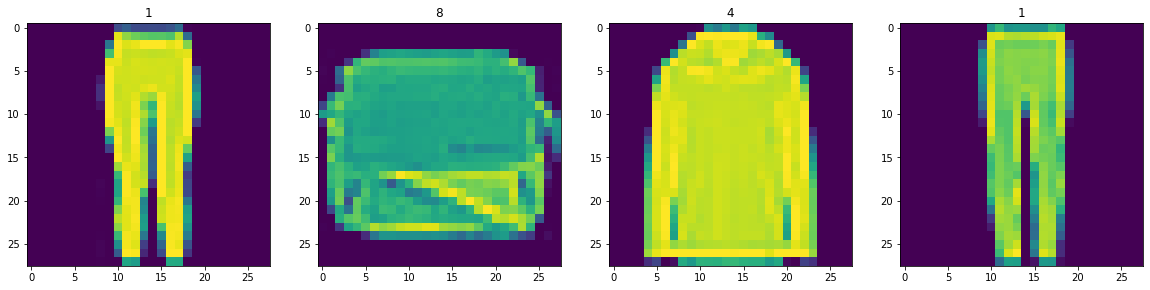

In [35]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
  sample = dataiterator.next()
  ax[idx].imshow(np.squeeze(sample["image"]))
  ax[idx].title.set_text(sample["label"])

In [36]:
def scale_image(data):
  image = data["image"]
  return image / 255

In [37]:
ds = tfds.load("fashion_mnist", split="train")
ds = ds.map(scale_image)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [38]:
import tensorflow as tf
from tensorflow import keras

In [39]:
def build_generator():
  model = keras.Sequential([
      keras.layers.Dense(7 * 7 * 128, input_dim=128),
      keras.layers.LeakyReLU(0.2),
      keras.layers.Reshape((7, 7, 128)),

      keras.layers.UpSampling2D(),    
      keras.layers.Conv2D(128, 5, padding="same"),
      keras.layers.LeakyReLU(0.2),

      keras.layers.UpSampling2D(),    
      keras.layers.Conv2D(128, 5, padding="same"),
      keras.layers.LeakyReLU(0.2),

      keras.layers.Conv2D(128, 4, padding="same"),
      keras.layers.LeakyReLU(0.2),

      keras.layers.Conv2D(128, 4, padding="same"),
      keras.layers.LeakyReLU(0.2),

      keras.layers.Conv2D(1, 4, padding="same", activation="sigmoid")
  ])
  return model

In [40]:
generator = build_generator()

In [41]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [42]:
img = generator.predict(np.random.randn(4, 128, 1))

In [43]:
def build_discriminator():
  model = keras.Sequential([
    keras.layers.Conv2D(32, 5, input_shape=(28, 28, 1)),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(64, 5),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(128, 5),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, 5),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.4),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation="sigmoid")
  ])
  return model

In [44]:
discriminator = build_discriminator()

In [45]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)      

In [46]:
discriminator.predict(img)

array([[0.5021503 ],
       [0.50235   ],
       [0.50248843],
       [0.50261897]], dtype=float32)

In [47]:
g_opt = keras.optimizers.Adam(learning_rate=0.0001)
d_opt = keras.optimizers.Adam(learning_rate=0.00001)
g_loss = keras.losses.BinaryCrossentropy()
d_loss = keras.losses.BinaryCrossentropy()

In [48]:
class FashionGAN(keras.models.Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.generator = generator
    self.discriminator = discriminator
  
  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    super().compile(*args, **kwargs)
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss
  
  def train_step(self, batch):
    real_images = batch
    fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

    with tf.GradientTape() as d_tape:
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)

      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    with tf.GradientTape() as g_tape:
      gen_images = self.generator(tf.random.uniform((128, 128, 1)), training=True)
      predicted_labels = self.discriminator(gen_images, training=False)
      
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
    
    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return {"d_loss": total_d_loss, "g_loss": total_g_loss}

In [49]:
fashgan = FashionGAN(generator, discriminator)

In [50]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [51]:
hist = fashgan.fit(ds, epochs=20)

Epoch 1/20
469/469 [==============================] - 77s 150ms/step - d_loss: 0.6581 - g_loss: 0.5277
Epoch 2/20
469/469 [==============================] - 73s 156ms/step - d_loss: 0.5399 - g_loss: 0.3268
Epoch 3/20
469/469 [==============================] - 74s 157ms/step - d_loss: 0.5346 - g_loss: 0.3162
Epoch 4/20
469/469 [==============================] - 73s 155ms/step - d_loss: 0.3728 - g_loss: 0.1637
Epoch 5/20
469/469 [==============================] - 73s 156ms/step - d_loss: 0.3677 - g_loss: 0.3121
Epoch 6/20
469/469 [==============================] - 73s 155ms/step - d_loss: 0.3180 - g_loss: 0.2049
Epoch 7/20
469/469 [==============================] - 72s 155ms/step - d_loss: 0.2983 - g_loss: 0.7439
Epoch 8/20
469/469 [==============================] - 73s 155ms/step - d_loss: 0.3130 - g_loss: 0.4219
Epoch 9/20
469/469 [==============================] - 73s 156ms/step - d_loss: 0.2971 - g_loss: 0.1810
Epoch 10/20
469/469 [==============================] - 73s 156ms/step - d

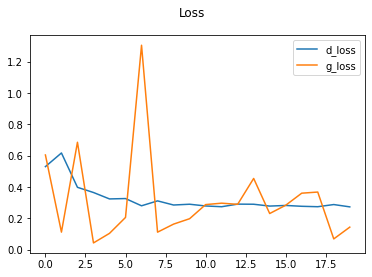

In [53]:
plt.suptitle("Loss")
plt.plot(hist.history["d_loss"], label="d_loss")
plt.plot(hist.history["g_loss"], label="g_loss")
plt.legend()
plt.show()

In [54]:
generator.save("./generator.h5")
discriminator.save("./discriminator.h5")